# Uproot and Awkward Arrays

## Tutorial for Electron Ion Collider users

Jim Pivarski (Princeton University)

In [133]:
import os
os.chdir("..")

## Table of contents

* [Uproot: getting data](#uproot)
    - [Exploring a TFile](#Exploring-a-TFile)
    - [Exploring a TTree](#Exploring-a-TTree)
    - [Turning ROOT branches into NumPy arrays](#Turning-ROOT-branches-into-NumPy-arrays)
    - [Memory management; caching and iteration](#Memory-management;-caching-and-iteration)
    - [Jagged arrays (segue)](#Jagged-arrays-(segue))
* [Awkward Array: manipulating data](#awkward)
    - [Using Uproot data in Awkward 1.0](#Using-Uproot-data-in-Awkward-1.0)
    - [Iteration in Python vs array-at-a-time operations](#Iteration-in-Python-vs-array-at-a-time-operations)
    - [Zipping arrays into records and projecting them back out](#Zipping-arrays-into-records-and-projecting-them-back-out)
    - [Filtering (cutting) events and particles with advanced selections](#Filtering-(cutting)-events-and-particles-with-advanced-selections)
    - [Flattening for plots and regularizing to NumPy for machine learning](#Flattening-for-plots-and-regularizing-to-NumPy-for-machine-learning)
    - [Broadcasting flat arrays and jagged arrays](#Broadcasting-flat-arrays-and-jagged-arrays)
    - [Combinatorics: cartesian and combinations](#Combinatorics:-cartesian-and-combinations)
    - [Reducing from combinations](#Reducing-from-combinations)
    - [Imperative, but still fast, programming in Numba](#Imperative,-but-still-fast,-programming-in-Numba)
    - [Grafting jagged data onto Pandas](#Grafting-jagged-data-onto-Pandas)
    - [NumExpr, Autograd, and other third-party libraries](#NumExpr,-Autograd,-and-other-third-party-libraries)

<br>
<br>
<a name="uproot"></a>
<img src="https://github.com/scikit-hep/uproot/raw/master/docs/source/logo-600px.png" width="300">

Uproot is a pure Python reimplementation of a significant part of ROOT I/O.

<br>
<img src="https://raw.githubusercontent.com/jpivarski/2019-07-29-dpf-python/master/img/abstraction-layers.png" width="700">
<br>

You can read TTrees containing basic data types, STL vectors, strings, and some more complex data, especially if it was written with a high "splitLevel".

You can also read histograms and other objects into generic containers, but the C++ methods that give those objects functionality are not available.

## Exploring a TFile

Uproot was designed to be Pythonic, so the way we interact with ROOT files is different than it is in ROOT.

In [2]:
import uproot
file = uproot.open("open_charm_18x275_10k.root")

A ROOT file may be thought of as a dict of key-value pairs, like a Python dict.

In [3]:
file.keys()

[b'events;1']

In [4]:
file.values()

[<ROOTDirectory b'events' at 0x7ff964c8a250>]

**What's the `b` before the name?** All strings retrieved from ROOT are unencoded, which Python 3 treats differently from Python 2. In the near future, Uproot will automatically interpret all strings from ROOT as UTF-8 and this cosmetic issue will be gone.

**What's the `;1` at the end of the name?** It's the cycle number, something ROOT uses to track multiple versions of an object. You can usually ignore it.

Nested directories are a dict of dicts.

In [5]:
file["events"].keys()

[b'tree;2', b'tree;1']

In [6]:
file["events"]["tree"]

<TTree b'tree' at 0x7ff964c67cd0>

But there are shortcuts:

   * use a `/` to navigate through the levels in a single string;
   * use `allkeys` to recursively show all keys in all directories.

In [7]:
file.allkeys()

[b'events;1', b'events/tree;2', b'events/tree;1']

In [8]:
file["events/tree"]

<TTree b'tree' at 0x7ff964ade2d0>

## Exploring a TTree

A TTree can also be thought of as a dict of dicts, this time to navigate through TBranches.

In [9]:
tree = file["events/tree"]
tree.keys()

[b'evt_id',
 b'evt_true_q2',
 b'evt_true_x',
 b'evt_true_y',
 b'evt_true_w2',
 b'evt_true_nu',
 b'evt_has_dis_info',
 b'evt_prt_count',
 b'evt_weight',
 b'id',
 b'pdg',
 b'trk_id',
 b'charge',
 b'dir_x',
 b'dir_y',
 b'dir_z',
 b'p',
 b'px',
 b'py',
 b'pz',
 b'tot_e',
 b'm',
 b'time',
 b'is_beam',
 b'is_stable',
 b'gen_code',
 b'mother_id',
 b'mother_second_id',
 b'has_pol_info',
 b'pol_x',
 b'pol_y',
 b'pol_z',
 b'has_vtx_info',
 b'vtx_id',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'vtx_t',
 b'has_smear_info',
 b'smear_has_e',
 b'smear_has_p',
 b'smear_has_pid',
 b'smear_has_vtx',
 b'smear_has_any_eppid',
 b'smear_orig_tot_e',
 b'smear_orig_p',
 b'smear_orig_px',
 b'smear_orig_py',
 b'smear_orig_pz',
 b'smear_orig_vtx_x',
 b'smear_orig_vtx_y',
 b'smear_orig_vtx_z']

Often, the first thing I do when I look at a TTree is `show` to see how each branch is going to be interpreted.

In [14]:
print("branch name              streamer (for complex data)  interpretation in Python")
print("==============================================================================")

tree.show()

branch name              streamer (for complex data)  interpretation in Python
evt_id                     (no streamer)              asdtype('>u8')
evt_true_q2                (no streamer)              asdtype('>f8')
evt_true_x                 (no streamer)              asdtype('>f8')
evt_true_y                 (no streamer)              asdtype('>f8')
evt_true_w2                (no streamer)              asdtype('>f8')
evt_true_nu                (no streamer)              asdtype('>f8')
evt_has_dis_info           (no streamer)              asdtype('int8')
evt_prt_count              (no streamer)              asdtype('>u8')
evt_weight                 (no streamer)              asdtype('>f8')
id                         (no streamer)              asjagged(asdtype('>u8'))
pdg                        (no streamer)              asjagged(asdtype('>i8'))
trk_id                     (no streamer)              asjagged(asdtype('>f8'))
charge                     (no streamer)              asjagged

Most of the information you'd expect to find in a TTree is there. See [uproot.readthedocs.io](https://uproot.readthedocs.io/en/latest/ttree-handling.html) for a complete list.

In [20]:
tree.numentries

10000

In [27]:
tree["evt_id"].compressedbytes(), tree["evt_id"].uncompressedbytes(), tree["evt_id"].compressionratio()

(15417, 80000, 5.189076992929882)

In [25]:
tree["evt_id"].numbaskets

3

In [26]:
[tree["evt_id"].basket_entrystart(i) for i in range(3)]

[0, 3990, 5883]

## Turning ROOT branches into NumPy arrays

There are several methods for this; they differ only in convenience.

In [30]:
# TBranch → array
tree["evt_id"].array()

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [31]:
# TTree + branch name → array
tree.array("evt_id")

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [33]:
# TTree + branch names → arrays
tree.arrays(["evt_id", "evt_prt_count"])

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64)}

In [34]:
# TTree + branch name pattern(s) → arrays
tree.arrays("evt_*")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

In [41]:
# TTree + branch name regex(s) → arrays
tree.arrays("/evt_[A-Z_0-9]*/i")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #1:** turn the bytestrings into real strings (will soon be unnecessary).

In [42]:
tree.arrays("evt_*", namedecode="utf-8")

{'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #2:** output a tuple instead of a dict.

In [44]:
tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 array([51, 26, 27, ..., 42, 25, 11], dtype=uint64))

... to use it in assignment:

In [45]:
evt_id, evt_prt_count = tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

In [46]:
evt_id

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

## Memory management; caching and iteration

The `array` methods read an entire branch into memory. Sometimes, you might not have enough memory to do that.

The simplest solution is to set `entrystart` (inclusive) and `entrystop` (exclusive) to read a small batch at a time.

In [47]:
tree.array("evt_id", entrystart=500, entrystop=600)

array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599], dtype=uint64)

Uproot is _not_ agressive about caching: if you call `arrays` many times (for many small batches), it will read from the file every time.

You can avoid frequent re-reading by assigning arrays to variables, but then you'd have to manage all those variables.

**Instead, use explicit caching:**

In [49]:
# Make a cache with an acceptable limit.
gigabyte_cache = uproot.ArrayCache("1 GB")

# Read the array from disk:
tree.array("evt_id", cache=gigabyte_cache)

# Get the array from the cache:
tree.array("evt_id", cache=gigabyte_cache)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

The advantage is that the same code can be used for first time and subsequent times. You can put this in a loop.

Naturally, fetching from the cache is much faster than reading from disk (though our file isn't very big!).

In [55]:
%%timeit

tree.arrays("*")

564 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit

tree.arrays("*", cache=gigabyte_cache)

2.07 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The value of an explicit cache is that you get to control it.

In [58]:
len(gigabyte_cache)

52

In [59]:
gigabyte_cache.clear()

In [60]:
len(gigabyte_cache)

0

Setting `entrystart` and `entrystop` can get annoying; we probably want to do it in a loop.

There's a method, `iterate`, for that.

In [61]:
for arrays in tree.iterate("evt_*", entrysteps=1000):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id'

Keep in mind that this is a loop over _batches_, not _events_.

What goes in the loop is code that applies to _arrays_.

You can also set the `entrysteps` to be a size in memory.

In [63]:
for arrays in tree.iterate("evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

The same size in memory covers more events if you read fewer branches.

In [64]:
for arrays in tree.iterate("evt_id", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 10000}


This `TTree.iterate` method is similar in form to the `uproot.iterate` function, which iterates in batches over a collection of files.

In [66]:
for arrays in uproot.iterate(["open_charm_18x275_10k.root",
                              "open_charm_18x275_10k.root",
                              "open_charm_18x275_10k.root"], "events/tree", "evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

## Jagged arrays (segue)

Most of the branches in this file have an "asjagged" interpretation, instead of "asdtype" (NumPy).

In [127]:
tree["evt_id"].interpretation

asdtype('>u8')

In [67]:
tree["pdg"].interpretation

asjagged(asdtype('>i8'))

This means that they have multiple values per entry.

In [68]:
tree["pdg"].array()

<JaggedArray [[11 211 -211 ... 22 22 22] [11 211 -211 ... -211 22 22] [11 2112 2212 ... 22 22 -211] ... [11 -211 321 ... 22 22 22] [11 2112 -211 ... 22 22 130] [11 -211 -321 ... 130 22 22]] at 0x7ff964e568d0>

Jagged arrays (lists of variable-length sublists) are very common in particle physics, and surprisingly uncommon in other fields.

We need them because we almost always have a variable number of particles per event.

In [126]:
from particle import Particle     # https://github.com/scikit-hep/particle

counter = 0
for event in tree["pdg"].array():
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

51 particles: e- pi+ pi- K- pi+ pi- pi- pi+ pi+ pi+ gamma gamma K(L)0 K+ pi- K(L)0 gamma gamma gamma gamma pi+ pi- pi+ gamma gamma p pi- pi+ K+ pi- pi- K+ K- gamma gamma pi+ pi- K+ pi- pi+ K(L)0 K(L)0 gamma gamma pi+ pi- pi+ gamma gamma gamma gamma
26 particles: e- pi+ pi- n~ n gamma pi- pi+ gamma gamma pi+ gamma gamma gamma gamma gamma K(L)0 gamma gamma gamma gamma pi- pi+ pi- gamma gamma
27 particles: e- n p pi+ pi+ pi+ pi- pi- pi- pi- pi- pi+ pi- gamma gamma gamma pi+ K+ K- pi+ gamma gamma gamma gamma gamma gamma pi-
28 particles: e- pi+ pi- nu(mu) mu+ gamma gamma pi- pi+ n gamma gamma n pi- p~ pi+ gamma gamma pi+ pi- K- K(L)0 gamma gamma gamma gamma gamma gamma
30 particles: e- pi+ pi- pi+ pi- n gamma gamma K- pi+ n pi- pi+ gamma n~ p~ pi+ K(L)0 gamma gamma pi- gamma gamma pi- pi+ gamma gamma K+ pi- gamma
12 particles: e- gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma
25 particles: pi- K- K+ pi- gamma gamma pi- gamma gamma pi- K(L)0 K(L)0 gamma gamma gamma gamma 

Although you can iterate over jagged arrays with for loops, the idiomatic and faster way to do it is with array-at-a-time functions.

In [128]:
import numpy as np

vtx_x, vtx_y, vtx_z = tree.arrays(["vtx_[xyz]"], outputtype=tuple)

vtx_dist = np.sqrt(vtx_x**2 + vtx_y**2 + vtx_z**2)

vtx_dist

<JaggedArray [[0.010869109735358505 0.04461569970007986 0.018400738439694277 ... 3.1836758411592023 3.183642553033989 3.183642553033989] [0.00044890687568113205 0.03373796683736145 0.05401859969095815 ... 131.99585878615915 0.028563725689861715 0.028563725689861715] [0.036756813467945904 4.486285131592035e-10 0.04416327313376598 ... 1.2533205300290502 1.2533205300290502 0.5367743154487575] ... [0.008254781290207314 0.01227106989388853 0.018030435962753534 ... 2.5798363404850953e-05 1.3027315899452183 1.3027315899452183] [0.0007829175274973732 4.5649022026043563e-10 0.00177464214391142 ... 0.00013687824404269707 0.00013687824404269707 8.543815169675133] [0.03541578165022657 0.002674912324039225 0.008526111534115434 ... 0.36799639096494413 0.3687648973563558 0.3687648973563558]] at 0x7ff92c402c50>

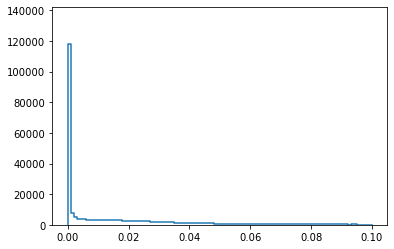

In [84]:
import matplotlib.pyplot as plt
import mplhep as hep             # https://github.com/scikit-hep/mplhep
import boost_histogram as bh     # https://github.com/scikit-hep/boost-histogram

vtx_hist = bh.Histogram(bh.axis.Regular(100, 0, 0.1))

vtx_hist.fill(vtx_dist.flatten())

hep.histplot(vtx_hist)

In [85]:
vtx_dist > 0.01

<JaggedArray [[True True True ... True True True] [False True True ... True True True] [True False True ... True True True] ... [False True True ... False True True] [False False False ... False False True] [True False False ... True True True]] at 0x7ff933024c50>

In [86]:
pdg = tree["pdg"].array()
pdg[vtx_dist > 0.01]

<JaggedArray [[11 211 -211 ... 22 22 22] [211 -211 -211 ... -211 22 22] [11 2212 211 ... 22 22 -211] ... [-211 321 -321 ... -211 22 22] [211 -211 211 ... 211 -211 130] [11 2112 -211 ... 130 22 22]] at 0x7ff932f947d0>

In [125]:
counter = 0
for event in pdg[vtx_dist > 0.10]:
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

16 particles: p pi- K+ pi- pi- pi+ pi- pi+ K(L)0 pi+ pi- pi+ gamma gamma gamma gamma
9 particles: pi- pi+ K(L)0 gamma gamma gamma gamma pi+ pi-
8 particles: pi- pi- K+ K- pi+ gamma gamma pi-
7 particles: nu(mu) mu+ pi+ pi- K- gamma gamma
8 particles: K- pi+ p~ pi+ pi- pi+ K+ pi-
6 particles: gamma gamma gamma gamma gamma gamma
2 particles: K- K(L)0
1 particles: n
0 particles: 
12 particles: K- pi+ pi- K(L)0 pi- pi+ gamma gamma gamma gamma gamma gamma
7 particles: pi+ pi- K(L)0 pi+ K- gamma gamma
10 particles: pi+ pi- nu(e)~ e- K+ K(L)0 gamma gamma gamma gamma
11 particles: n pi+ K- gamma gamma gamma gamma p~ pi+ pi+ pi-
6 particles: K+ pi+ pi- pi- gamma gamma
16 particles: pi- pi- pi+ gamma gamma pi- K- pi+ pi+ pi- gamma gamma gamma gamma gamma gamma
6 particles: K+ pi- gamma gamma gamma gamma
10 particles: pi- pi+ p~ e+ e- gamma gamma gamma gamma gamma
18 particles: n pi- n~ pi+ n pi+ pi- pi+ pi- p pi- n~ pi+ pi+ gamma gamma gamma gamma
11 particles: nu(e) e+ K- K+ pi- pi+ pi- gamma g

In [119]:
Particle.from_string("p~")

<Particle: name="p~", pdgid=-2212, mass=938.272081 ± 0.000006 MeV>

In [120]:
Particle.from_string("p~").pdgid

-2212

In [264]:
is_antiproton = (pdg == Particle.from_string("p~").pdgid)
is_antiproton

<JaggedArray [[False False False ... False False False] [False False False ... False False False] [False False False ... False False False] ... [False False False ... False False False] [False False False ... False False False] [False False False ... False False False]] at 0x7ff927ab3ad0>

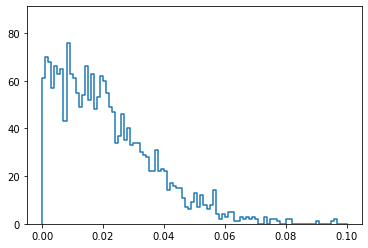

In [124]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 0.1)).fill(
    vtx_dist[is_antiproton].flatten()
))

But that's a topic for the next section.

<br>
<br>
<a name="awkward"></a>
<img src="https://github.com/scikit-hep/awkward-1.0/raw/master/docs-images/logo/logo-600px.png" width="400">

Awkward Array is a library for manipulating arbitrary data structures in a NumPy-like way.

The idea is that you have a large number of identically typed, nested objects in variable-length lists.

<img src="../docs-images/diagrams/cartoon-schematic.png" width="600">

## Using Uproot data in Awkward 1.0

Awkward Array is in transition from

   * version 0.x, which is in use at the LHC but has revealed some design flaws, to
   * version 1.x, which is well-architected and has completed development, but is not in widespread use yet.

Awkward 1.0 hasn't been incorporated into Uproot yet, which is how it will get in front of most users.

Since development is complete and the interface is (intentionally) different, I thought it better to show you the new version.

In [134]:
import awkward1 as ak

Old-style arrays can be converted into the new framework with `ak.from_awkward0`. This won't be a necessary step for long.

In [136]:
ak.from_awkward0(tree.array("pdg"))

<Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>

In [139]:
arrays = {name: ak.from_awkward0(array) for name, array in tree.arrays(namedecode="utf-8").items()}
arrays

{'evt_id': <Array [0, 1, 2, 3, ... 9996, 9997, 9998, 9999] type='10000 * uint64'>,
 'evt_true_q2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_x': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_y': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_w2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_nu': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_has_dis_info': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * int8'>,
 'evt_prt_count': <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>,
 'evt_weight': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'id': <Array [[12, 79, 80, 81, ... 54, 60, 61, 62]] type='10000 * var * uint64'>,
 'pdg': <Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>,
 'trk_id': <Array [[0, 0, 0, 0, 0, 0,

## Iteration in Python vs array-at-a-time operations

As before, you _can_ iterate over them in Python, but only do that for small-scale exploration.

In [147]:
%%timeit -n1 -r1

vtx_dist = []
for xs, xy, xz in zip(arrays["vtx_x"], arrays["vtx_y"], arrays["vtx_z"]):
    out = []
    for x, y, z in zip(xs, xy, xz):
        out.append(np.sqrt(x**2 + y**2 + z**2))
    vtx_dist.append(out)

10.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [148]:
%%timeit -n100 -r1

vtx_dist = np.sqrt(arrays["vtx_x"]**2 + arrays["vtx_y"]**2 + arrays["vtx_z"]**2)

18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


## Zipping arrays into records and projecting them back out

Instead of having all these arrays floating around, let's group them into a structure.

In [171]:
events = ak.zip({"id": arrays["evt_id"],
                 "true": ak.zip({"q2": arrays["evt_true_q2"],
                                 "x": arrays["evt_true_x"],
                                 "y": arrays["evt_true_y"],
                                 "w2": arrays["evt_true_w2"],
                                 "nu": arrays["evt_true_nu"]}),
                 "has_dis_info": arrays["evt_has_dis_info"],
                 "prt_count": arrays["evt_prt_count"],
                 "prt": ak.zip({"id": arrays["id"],
                                "pdg": arrays["pdg"],
                                "trk_id": arrays["trk_id"],
                                "charge": arrays["charge"],
                                "dir": ak.zip({"x": arrays["dir_x"],
                                               "y": arrays["dir_y"],
                                               "z": arrays["dir_z"]}, with_name="point3"),
                                "p": arrays["p"],
                                "px": arrays["px"],
                                "py": arrays["py"],
                                "pz": arrays["pz"],
                                "m": arrays["m"],
                                "time": arrays["time"],
                                "is_beam": arrays["is_beam"],
                                "is_stable": arrays["is_stable"],
                                "gen_code": arrays["gen_code"],
                                "mother": ak.zip({"id": arrays["mother_id"],
                                                  "second_id": arrays["mother_second_id"]}),
                                "pol": ak.zip({"has_info": arrays["has_pol_info"],
                                               "x": arrays["pol_x"],
                                               "y": arrays["pol_y"],
                                               "z": arrays["pol_z"]}, with_name="point3"),
                                "vtx": ak.zip({"has_info": arrays["has_vtx_info"],
                                               "id": arrays["vtx_id"],
                                               "x": arrays["vtx_x"],
                                               "y": arrays["vtx_y"],
                                               "z": arrays["vtx_z"],
                                               "t": arrays["vtx_t"]}, with_name="point3"),
                                "smear": ak.zip({"has_info": arrays["has_smear_info"],
                                                 "has_e": arrays["smear_has_e"],
                                                 "has_p": arrays["smear_has_p"],
                                                 "has_pid": arrays["smear_has_pid"],
                                                 "has_vtx": arrays["smear_has_vtx"],
                                                 "has_any_eppid": arrays["smear_has_any_eppid"],
                                                 "orig": ak.zip({"tot_e": arrays["smear_orig_tot_e"],
                                                                 "p": arrays["smear_orig_p"],
                                                                 "px": arrays["smear_orig_px"],
                                                                 "py": arrays["smear_orig_py"],
                                                                 "pz": arrays["smear_orig_pz"],
                                                                 "vtx": ak.zip({"x": arrays["smear_orig_vtx_x"],
                                                                                "y": arrays["smear_orig_vtx_y"],
                                                                                "z": arrays["smear_orig_vtx_z"]},
                                                                               with_name="point3")})})})},
                depthlimit=1)

ak.type(events)

10000 * {"id": uint64, "true": {"q2": float64, "x": float64, "y": float64, "w2": float64, "nu": float64}, "has_dis_info": int8, "prt_count": uint64, "prt": var * {"id": uint64, "pdg": int64, "trk_id": float64, "charge": float64, "dir": point3["x": float64, "y": float64, "z": float64], "p": float64, "px": float64, "py": float64, "pz": float64, "m": float64, "time": float64, "is_beam": bool, "is_stable": bool, "gen_code": bool, "mother": {"id": uint64, "second_id": uint64}, "pol": point3["has_info": float64, "x": float64, "y": float64, "z": float64], "vtx": point3["has_info": bool, "id": uint64, "x": float64, "y": float64, "z": float64, "t": float64], "smear": {"has_info": bool, "has_e": bool, "has_p": bool, "has_pid": bool, "has_vtx": bool, "has_any_eppid": bool, "orig": {"tot_e": float64, "p": float64, "px": float64, "py": float64, "pz": float64, "vtx": point3["x": float64, "y": float64, "z": float64]}}}}

The type written with better formatting:

```javascript
10000 * {"id": uint64,
         "true": {"q2": float64,
                  "x": float64,
                  "y": float64,
                  "w2": float64,
                  "nu": float64},
         "has_dis_info": int8,
         "prt_count": uint64,

         "prt": var * {"id": uint64,
                       "pdg": int64,
                       "trk_id": float64,
                       "charge": float64,
                       "dir": point3["x": float64, "y": float64, "z": float64],
                       "p": float64,
                       "px": float64,
                       "py": float64,
                       "pz": float64,
                       "m": float64,
                       "time": float64,
                       "is_beam": bool,
                       "is_stable": bool,
                       "gen_code": bool,
                       "mother": {"id": uint64, "second_id": uint64},
                       "pol": point3["has_info": float64,
                                     "x": float64,
                                     "y": float64,
                                     "z": float64],
                       "vtx": point3["has_info": bool,
                                     "id": uint64,
                                     "x": float64,
                                     "y": float64,
                                     "z": float64,
                                     "t": float64],
                       "smear": {"has_info": bool,
                                 "has_e": bool,
                                 "has_p": bool,
                                 "has_pid": bool,
                                 "has_vtx": bool,
                                 "has_any_eppid": bool,
                                 "orig": {"tot_e":
                                          float64,
                                          "p": float64,
                                          "px": float64,
                                          "py": float64,
                                          "pz": float64,
                                          "vtx": point3["x": float64,
                                                        "y": float64,
                                                        "z": float64]}}}}
```

It means that these are now nested objects.

In [181]:
ak.to_list(events[0].prt[0])

{'id': 12,
 'pdg': 11,
 'trk_id': 0.0,
 'charge': -1.0,
 'dir': {'x': 0.027552974158427224,
  'y': -0.159486986156017,
  'z': 0.9868154512683186},
 'p': 3.2559399993304847,
 'px': -0.5164342370904987,
 'py': 0.08917945577907008,
 'pz': 3.2134853325739483,
 'm': 0.0,
 'time': 0.0,
 'is_beam': False,
 'is_stable': False,
 'gen_code': False,
 'mother': {'id': 0, 'second_id': 0},
 'pol': {'has_info': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0},
 'vtx': {'has_info': True,
  'id': 0,
  'x': -0.0002629100828319597,
  'y': 0.008004273764408541,
  'z': 0.007348471013211623,
  't': 0.0},
 'smear': {'has_info': True,
  'has_e': True,
  'has_p': True,
  'has_pid': False,
  'has_vtx': True,
  'has_any_eppid': True,
  'orig': {'tot_e': 3.2399370783466463,
   'p': 3.239937038049433,
   'px': 0.08926990148430726,
   'py': -0.5167277935337566,
   'pz': 3.1972199302836906,
   'vtx': {'x': 0.0, 'y': 0.0, 'z': 0.0}}}}

In [180]:
ak.to_list(events[-1].prt[:10].smear.orig.vtx)

[{'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': -6.110853575363856e-12,
  'y': -2.4888797620237205e-12,
  'z': -1.0095678734711646e-10},
 {'x': -7.214024530021195e-12,
  'y': -2.801047134360359e-12,
  'z': -1.0233975313075053e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -2.1591646092697467, 'y': 0.9341721743864254, 'z': -527.4931103722447},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04451351075293813,
  'y': -0.013705013997490656,
  'z': -0.36581179515431195}]

Alternatively,

In [204]:
ak.to_list(events[-1, "prt", :10, "smear", "orig", "vtx"])

[{'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': -6.110853575363856e-12,
  'y': -2.4888797620237205e-12,
  'z': -1.0095678734711646e-10},
 {'x': -7.214024530021195e-12,
  'y': -2.801047134360359e-12,
  'z': -1.0233975313075053e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -2.1591646092697467, 'y': 0.9341721743864254, 'z': -527.4931103722447},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04451351075293813,
  'y': -0.013705013997490656,
  'z': -0.36581179515431195}]

<img src="../docs-images/diagrams/how-it-works-muons.png" width="1000">

"Zipping" arrays together into structures costs nothing (time does not scale with size of data), nor does "projecting" arrays out of structures.

In [184]:
events.prt.px

<Array [[-0.516, -0.246, ... -0.0205, -0.377]] type='10000 * var * float64'>

In [185]:
events.prt.py

<Array [[0.0892, 0.548, ... 0.0232, 0.043]] type='10000 * var * float64'>

In [186]:
events.prt.pz

<Array [[3.21, -2.11, ... -0.0904, -3.02]] type='10000 * var * float64'>

This is called "projection" because the request for `"pz"` is slicing through arrays and jagged arrays.

The following are equivalent:

In [191]:
events[999, "prt", 12, "pz"]

-1.2469826742751766

In [192]:
events["prt", 999, 12, "pz"]

-1.2469826742751766

In [193]:
events[999, "prt", "pz", 12]

-1.2469826742751766

In [194]:
events["prt", 999, "pz", 12]

-1.2469826742751766

This "object oriented view" is a conceptual aid, not a constraint on computation. It's very fluid.

Moreover, we can add behaviors to named records, like methods in object oriented programming.

In [196]:
def point3_absolute(data):
    return np.sqrt(data.x**2 + data.y**2 + data.z**2)

def point3_distance(left, right):
    return np.sqrt((left.x - right.x)**2 + (left.y - right.y)**2 + (left.z - right.z)**2)

ak.behavior[np.absolute, "point3"] = point3_absolute
ak.behavior[np.subtract, "point3", "point3"] = point3_distance

In [183]:
# Absolute value of all smear origin vertexes
abs(events.prt.smear.orig.vtx)

<Array [[0, 2.34e-10, ... 0.369, 0.369]] type='10000 * var * float64'>

In [188]:
# Absolute value of the last smear origin vertex
abs(events[-1].prt[-1].smear.orig.vtx)

0.3687648973563558

In [197]:
# Distance between each particle vertex and itself
events.prt.vtx - events.prt.vtx

<Array [[0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0]] type='10000 * var * float64'>

In [203]:
# Distances between the first and last particle vertexes in the first 100 events
events.prt.vtx[:100, 0] - events.prt.vtx[:100, -1]

<Array [3.18, 0.0284, 0.554, ... 45.1, 0.142] type='100 * float64'>

## Filtering (cutting) events and particles with advanced selections

NumPy has a versatile selection mechanism:

<img src="https://raw.githubusercontent.com/jpivarski/2019-07-23-codas-hep/master/img/numpy-slicing.png" width="300">

The same expressions apply to Awkward Arrays, and more.

In [206]:
# First particle momentum in the first 5 events
events.prt.p[:5, 0]

<Array [3.26, 15.8, 17.9, 14.5, 7.33] type='5 * float64'>

In [229]:
# First two particles in all events
events.prt.pdg[:, :2]

<Array [[11, 211], [11, ... 2112], [11, -211]] type='10000 * var * int64'>

In [217]:
# First direction of the last event
events.prt.dir[-1, 0]

<Record {x: 0.0809, y: 0.0151, z: 0.997} type='point3["x": float64, "y": float64...'>

NumPy also lets you filter (cut) using an array of booleans.

In [222]:
events.prt_count > 100

<Array [False, False, False, ... False, False] type='10000 * bool'>

In [223]:
np.count_nonzero(events.prt_count > 100)

16

In [221]:
events[events.prt_count > 100]

<Array [{id: 734, true: {q2: 0, x: 0, ... ] type='16 * {"id": uint64, "true": {"...'>

One dimension can be selected with an array while another is selected with a slice.

In [227]:
# Select events with at least two particles, then select the first two particles
events.prt[events.prt_count >= 2, :2]

<Array [[{id: 12, pdg: 11, trk_id: 0, ... ] type='9963 * var * {"id": uint64, "p...'>

This can be a good way to avoid errors from trying to select what isn't there.

In [236]:
try:
    events.prt[:, 0]
except Exception as err:
    print(type(err).__name__, str(err))

ValueError in ListArray64 attempting to get 0, index out of range


In [235]:
events.prt[events.prt_count > 0, 0]

<Array [{id: 12, pdg: 11, trk_id: 0, ... ] type='9964 * {"id": uint64, "pdg": in...'>

See also [awkward-array.readthedocs.io](https://awkward-array.readthedocs.io/) for a list of operations like ak.num:

In [237]:
ak.num(events.prt), events.prt_count

(<Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * int64'>,
 <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>)

You can even use an array of integers to select a set of indexes at once.

In [242]:
# First and last particle in each event that has at least two
events.prt.pdg[ak.num(events.prt) >= 2][:, [0, -1]]

<Array [[11, 22], [11, 22, ... 130], [11, 22]] type='9963 * 2 * int64'>

But beyond NumPy, we can also use arrays of nested lists as boolean or integer selectors.

In [247]:
# Array of lists of True and False
abs(events.prt.vtx) > 0.10

<Array [[False, False, False, ... True, True]] type='10000 * var * bool'>

In [249]:
# Particles that have vtx > 0.10 for all events (notice that there's still 10000)
events.prt[abs(events.prt.vtx) > 0.10]

<Array [[{id: 125, pdg: 2212, ... ] type='10000 * var * {"id": uint64, "pdg": in...'>

See [awkward-array.readthedocs.io](https://awkward-array.readthedocs.io/) for more, but there are functions like ak.max, which picks the maximum in a groups.

   * With `axis=0`, the group is the set of all events.
   * With `axis=1`, the groups are particles in each event.

In [251]:
ak.max(abs(events.prt.vtx), axis=1)

<Array [889, 132, 1.26, ... 15.5, 39.7, 527] type='10000 * ?float64'>

In [257]:
# Selects *events* that have a maximum *particle vertex* greater than 100
events[ak.max(abs(events.prt.vtx), axis=1) > 100]

<Array [{id: 0, true: {q2: 0, x: 0, ... ] type='5535 * ?{"id": uint64, "true": {...'>

The difference between "select particles" and "select events" is the number of jagged dimensions in the array; "reducers" like ak.max reduce the dimensionality by one.

There are other reducers like ak.any, ak.all, ak.sum...

In [263]:
# Is this particle an antineutron?
events.prt.pdg == Particle.from_string("n~").pdgid

<Array [[False, False, ... False, False]] type='10000 * var * bool'>

In [265]:
# Are any particles in the event antineutrons?
ak.any(events.prt.pdg == Particle.from_string("n~").pdgid, axis=1)

<Array [False, True, False, ... False, False] type='10000 * bool'>

In [266]:
# Select events that contain an antineutron
events[ak.any(events.prt.pdg == Particle.from_string("n~").pdgid, axis=1)]

<Array [{id: 1, true: {q2: 0, x: 0, ... ] type='4130 * {"id": uint64, "true": {"...'>

## Flattening for plots and regularizing to NumPy for machine learning

## Broadcasting flat arrays and jagged arrays

## Combinatorics: cartesian and combinations

In [442]:
piplus = events.prt[(events.prt.pdg == Particle.from_string("pi+").pdgid) & (abs(events.prt.vtx) > 0.03)]
piminus = events.prt[(events.prt.pdg == Particle.from_string("pi-").pdgid) & (abs(events.prt.vtx) > 0.03)]

In [443]:
def mass(pair, left_mass, right_mass):
    left, right = ak.unzip(pair)
    left_energy = np.sqrt(left.p**2 + left_mass**2)
    right_energy = np.sqrt(right.p**2 + right_mass**2)
    return np.sqrt((left_energy + right_energy)**2 -
                   (left.px + right.px)**2 -
                   (left.py + right.py)**2 -
                   (left.pz + right.pz)**2)

In [444]:
pairwise_masses = mass(ak.cartesian([piplus, piminus]), 0.139570, 0.139570)
pairwise_masses

<Array [[0.525, 4.09, 2.44, ... [0.529]] type='10000 * var * float64'>

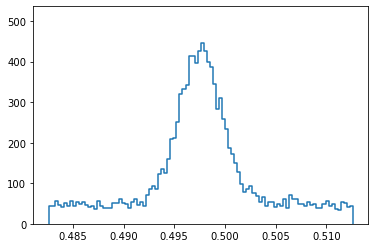

In [449]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.497611 - 0.015, 0.497611 + 0.015)).fill(
    ak.flatten(pairwise_masses)
))

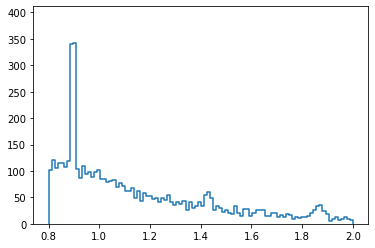

In [416]:
kminus = events.prt[(events.prt.pdg == Particle.from_string("K-").pdgid) & (abs(events.prt.vtx) > 0.10)]
piplus = events.prt[(events.prt.pdg == Particle.from_string("pi+").pdgid) & (abs(events.prt.vtx) > 0.10)]

pairwise_masses = mass(ak.cartesian([kminus, piplus]), 0.493677, 0.139570)
pairwise_masses

hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.8, 2)).fill(
    ak.flatten(pairwise_masses)
))

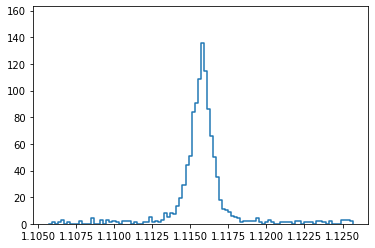

In [430]:
proton = events.prt[(events.prt.pdg == Particle.from_string("p").pdgid) & (abs(events.prt.vtx) > 0.10)]
piminus = events.prt[(events.prt.pdg == Particle.from_string("pi-").pdgid) & (abs(events.prt.vtx) > 0.10)]

pairwise_masses = mass(ak.cartesian([proton, piminus]), 0.938272, 0.139570)
pairwise_masses

hep.histplot(bh.Histogram(bh.axis.Regular(100, 1.115683 - 0.01, 1.115683 + 0.01)).fill(
    ak.flatten(pairwise_masses)
))

## Reducing from combinations

## Imperative, but still fast, programming in Numba

## Grafting jagged data onto Pandas

## NumExpr, Autograd, and other third-party libraries